# Redes Neurais Recorrentes

Long-Short Term Memory (LSTM) são um tipo de rede neural, mais especificamente um tipo de rede neural recorrente.

Redes neurais recorrentes possuem uma característica distinta de redes neurais feedforward. Ao invés da informação seguir um fluxo contínuo sempre em um direção (usualmente para "frente"), as RNNs passam a informação também de volta ("trás"). Isso permite que essas simulem uma memória, sendo capazes de lidar melhor com problemas que variam com o tempo, como é o nosso caso.

In [1]:
import torch
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

Vamos gerar alguns dados e visualizar como eles estão distribuídos usando o SkLearn, como vimos em aulas passadas!

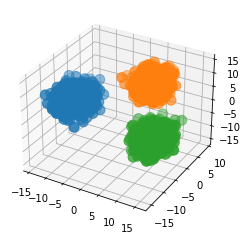

In [2]:
dummies = make_blobs(n_samples=3000, n_features=3, centers=3, cluster_std=2)
feats, labels = dummies
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, mark, color in zip(range(3), ['o', '^', 'x'], ['red', 'blue', 'green']):
    cls_samples = feats[labels == i]
    xoord = cls_samples[:, 0]
    yoord = cls_samples[:, 1]
    zoord = cls_samples[:, 2]
    scatter = ax.scatter(xoord, yoord, zoord, marker='o', s=100)

plt.show()
plt.close()

In [3]:
# transformando os dados numpy to tensor

Acima, nos transformamos a base blob criada para um formato usado pelos modelos do framework. Também poderíamos usar o método `from_numpy`. A diferença seria o último cria uma view do array original, enquanto que o outro cria uma cópia.

In [4]:
# view vs copia

## Tensores

É a principal estrutura de dado do framework. Ela é essencialmente um array numpy de 3 dimensões. Entretanto, com tensores é possível realizar operações diretamente na GPU aumentando a eficiência dos algoritmos.

In [27]:
torch.rand(2, 3, 2)

tensor([[[0.8793, 0.8956],
         [0.3373, 0.2148],
         [0.7246, 0.4908]],

        [[0.4441, 0.2831],
         [0.1393, 0.4045],
         [0.7032, 0.2610]]])

Temos suporte direto a operações aritméticas assim como no numPy. Podemos realizar adições (`+`), subtrações (`-`), multiplicação por escalar (`*`), transposição (`T` ou `transp()`), produto de hadarmard (`*`), produto interno (`@`), entre outros.

In [32]:
A = torch.ones(2, 3, 2) * 2
I = torch.eye(3, 2)

In [33]:
A

tensor([[[2., 2.],
         [2., 2.],
         [2., 2.]],

        [[2., 2.],
         [2., 2.],
         [2., 2.]]])

In [34]:
I

tensor([[1., 0.],
        [0., 1.],
        [0., 0.]])

In [35]:
A + I

tensor([[[3., 2.],
         [2., 3.],
         [2., 2.]],

        [[3., 2.],
         [2., 3.],
         [2., 2.]]])

In [36]:
A * I

tensor([[[2., 0.],
         [0., 2.],
         [0., 0.]],

        [[2., 0.],
         [0., 2.],
         [0., 0.]]])

In [37]:
A * I == A @ I

RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x2 and 3x2)

In [38]:
A @ torch.eye(2)

tensor([[[2., 2.],
         [2., 2.],
         [2., 2.]],

        [[2., 2.],
         [2., 2.],
         [2., 2.]]])

In [39]:
np.pi * A

tensor([[[6.2832, 6.2832],
         [6.2832, 6.2832],
         [6.2832, 6.2832]],

        [[6.2832, 6.2832],
         [6.2832, 6.2832],
         [6.2832, 6.2832]]])

In [44]:
rng = torch.rand(1, 3, 2)
A + rng

tensor([[[2.3022, 2.8603],
         [2.6469, 2.3742],
         [2.0272, 2.6507]],

        [[2.3022, 2.8603],
         [2.6469, 2.3742],
         [2.0272, 2.6507]]])

In [45]:
A.view(-1, 4)

tensor([[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]])

A execução na GPU não ocorre de forma automática. Primeiro, podemos verificar se o dispositivo é suportado pelo PyTorch.

In [47]:
torch.cuda.is_available()

False

In [ ]:
# gpu = torch.device("cuda")
# A.to(gpu)
# cuda_tensor = torch.tensor([3, 4, 5], device=gpu)

Em caso positivo, podemos especificar quais tensores terão suas operações executadas na placa gráfica, definir a execução de tudo por padrão.

## Rede Neural

O PyTorch permite criar modelos neurais com bastante facilidade e praticidade. Tanto a criação de modelos customizáveis e a grande quantidade de modelos prontos disponíveis é bastante simples. Por exemplo, abaixo podemos criar uma rede neural simples apenas usando os tensores

In [8]:
# tensor nn

O parâmetro `requires_grad` diz ao PyTorch que esse tensor deve ser levado em consideração quando algum otimizador for utilizado. Ou seja, no momento que fazemos a propagação do erro, esse tensor será atualizado.

In [9]:
# loss backprop

In [10]:
# tensor antes
# tensor depois

Note que os valores do tensor não foram atualizados após executar o backpropagation. Isso é porque os valores do gradiente são armazenados no atributo `grad` de cada tensor

In [11]:
# tensor.grad()

Agora, podemos atualizar o tensor com o seu gradiente. Aqui devemos tomar cuidado, pois o PyTorch controla e memoriza todas as operações realizadas nos tensores com `require_grad=True` para utilizar no cálculo dos gradientes. Para atualizar os parâmetros, não queremos que essa operação seja gravada. Para evitar esse comortamento, podemos usar o operador de contexto `with` com a função `torch.no_grad()`.

In [12]:
# atualiza tensor

Esse comportamento é devido a estratégia para automaticamente gerar o gradiente de qualquer estrutura. O PyTorch (e provavelmente outros) transforma o gradiente descendente/backpropagation em um grafo onde cada nó é uma operação. Assim, ele só precisa gerar a derivada de cada nó e aplicar o backpropagation.

### Otimizador

Também podemos selecionar qual tipo de otimizador usaremos para ajustar os parâmetros. O mais comum é o Stochastic Gradient Descent (SGD), mas o PyTorch oferece o Adadelta, Adagrad, RMSProp, entre vários outros dentro do pacoto `torch.optim`. Além disso, claro, também podemos customizar e criar o nosso próprio otimizador.

In [13]:
?torch.optim.RMSprop

Init signature:
torch.optim.RMSprop(
    params,
    lr=0.01,
    alpha=0.99,
    eps=1e-08,
    weight_decay=0,
    momentum=0,
    centered=False,
)
Docstring:     
Implements RMSprop algorithm.

Proposed by G. Hinton in his
`course <https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf>`_.

The centered version first appears in `Generating Sequences
With Recurrent Neural Networks <https://arxiv.org/pdf/1308.0850v5.pdf>`_.

The implementation here takes the square root of the gradient average before
adding epsilon (note that TensorFlow interchanges these two operations). The effective
learning rate is thus :math:`\alpha/(\sqrt{v} + \epsilon)` where :math:`\alpha`
is the scheduled learning rate and :math:`v` is the weighted moving average
of the squared gradient.

Arguments:
    params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
    lr (float, optional): learning rate (default: 1e-2)
    momentum (float, optional): momen

Em geral, os otimizadores são variações do Gradient Descent/Backpropagation. Mas alguns são melhores para evitar cair em mínimos locais, ou mesmo para quantidade de épocas necessárias. Outros, como o Adam, podem aumentar a complexidade da otimização ao utilizar valores diferentes para cada parâmetro, consequentemente aumentando também a flexibilidade.

In [14]:
# treinar com Adam

## Rede Recorrente

Para redes recorrentes também temos uma classe pronta para ser usada. 

In [15]:
# instancia rnn

O treinamento (backpropagation through time) é executado automaticamente com a seuinte instrução

In [16]:
# treina

Com o modelo treinado, podemos realizar nossos testes.

In [17]:
# testa

Usualmente, as classes do pacote `nn` são tratadas como layers. Ou seja, uma instância da RNN é um layer. Dessa forma, fica fácil gerar modelos complexos e altamente customizáveis. Por exemplo, podemos criar uma Rede Convolucional Recorrente entre outros franksteins.

In [18]:
# frankstein

### LSTM

Como vimos na parte teórica, a LSTM nada mais é que uma variação do "neurônio" de uma RNN.

![lstmhidden](imgs/lstmhidden.png)

O PyTorch também possui uma classe para o LSTM, tendo em vista sua popularidade.

In [19]:
# instancia LSTM

Na instância acima, definimos uma LSTM onde o *hidden state* possui dimensão $M\times N\times S$. Uma característica específica da LSTM nesse framework é a entrada esperada e o estado. Ambos devem ser tensores tridimensionais. Podemos treinar a rede ao propagar um elemento da sequência por vez

In [20]:
# treina 1 em 1

Enquanto que para usar todos os elementos precisamos concatenar nossos dados.

In [21]:
# todos de uma vez

Principalmente em NLP, a transformação do texto para representação numérica é bastante comum. Dessa forma, podemos criar uma LSTM customizada ao adicionar um layer de embedding que fica responsável por essa transformação.

In [22]:
# cria classe com embedding layer

Assim como podemos usar o novo layer durante o treinamento, aprendendo os embeddings de acordo com a task.

In [23]:
# treina embedding + lstm

Claro que também podemos criar vários franksteins, da mesma forma que fizemos com a RNN. Note que o *gradient descent* é totalmente genérico. Isto é, ele não depende da arquitetura do seu modelo, apenas que as funções de ativação sejam deriváveis ou deriváveis por partes. Por isso podemos criar estruturas totalmente **idiotas**, com valores indo, voltando, pulando, ignorando, com muito layer, e com o que quisermos.

In [24]:
# cria frankstein

É importante notar que redes profundas tendem a ocasionar *overfitting*, assim como os problemas decorrentes do algoritmo de aprendizado:

* Vanishing
* Exploding